# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfall in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [2]:
# !nvidia-smi

In [1]:
# # For summarizing and visualizing models
# !pip install torchinfo
# !pip install torchviz

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [3]:
# !pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [107]:
!wandb login e0017cd81972878a68df1df055a2758247ddb1b1

wandb: Appending key for api.wandb.ai to your netrc file: /Users/pupipatsingkhorn/.netrc


In [2]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.__version__ # 1.10.0+cu111

'2.2.1'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [4]:
# !tar -xvf '/content/gdrive/My Drive/nowcastingHWdataset.tar.gz'
!tar -xvf '/Users/pupipatsingkhorn/Library/CloudStorage/GoogleDrive-6210054308@student.triamudom.ac.th/My Drive/Y2/Pattern Recognition/HW/HW05/nowcastingHWdataset.tar.gz'

x dataset/features-m10.pk


x dataset/features-m6.pk
x dataset/features-m7.pk
x dataset/features-m8.pk
x dataset/features-m9.pk
x dataset/labels-m10.pk
x dataset/labels-m6.pk
x dataset/labels-m7.pk
x dataset/labels-m8.pk
x dataset/labels-m9.pk


# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [5]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [6]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [7]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:**

x_train shape: (229548 * 5, 5 * 5 * 3) = (1147740, 75)\
y_train shape: (229548 * 5, 1)

x_val shape: (92839 * 5, 5 * 5 * 3) = (464195, 75)\
y_val shape: (92839 * 5, 1) = (464195, 1)

x_test shape: (111715 * 5, 5 * 5 * 3) = (558575, 75)\
y_test shape: (111715 * 5) = (558575, 1)

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [8]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [9]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [10]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [12]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:** The mean squared error (MSE) loss is commonly used for regression tasks like precipitation nowcasting, where the goal is to predict a continuous valued output (the amount of rainfall). 

MSE measures the average squared difference between the predicted and actual values. It penalizes large errors more than small errors, making it suitable for regression problems where we want to minimize the overall error between the predictions and targets. Since precipitation is a continuous variable, MSE loss is an appropriate choice.

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [14]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:** The final dense layer uses a linear activation function. This is often used for regression tasks where the output is a continuous value, as it allows the model to output any real number. For classification tasks, a different activation function like softmax or sigmoid is typically used to output probabilities.

In [15]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

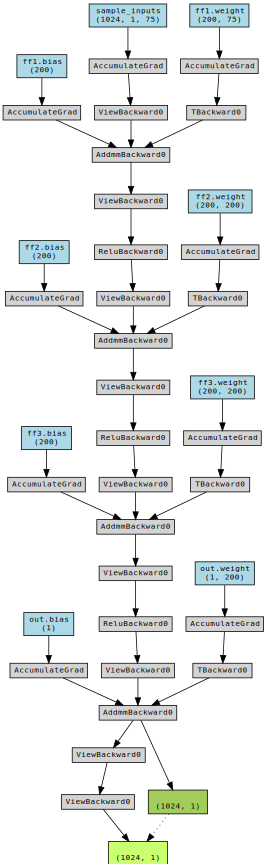

In [16]:
from torchviz import make_dot
# Visualize model with torchviz
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [17]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:**

Number of parameters = input size * hidden size + hidden size = 75 * 200 + 200 = 15,200

# Training

In [18]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pupipat-sk (pupipatsk). Use `wandb login --relogin` to force relogin


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9337
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6608
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9236
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6638
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9235
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6613
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9236
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6603
Saving new best model..
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9235
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6622
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9235
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6611
Training epoch 7...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9234
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6610
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9237
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6616
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9235
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6614
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9233
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6611


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,███████▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▂█▃▁▅▃▂▄▃▃
lr,0.002
train_loss,1.92332
val_loss,1.66113


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

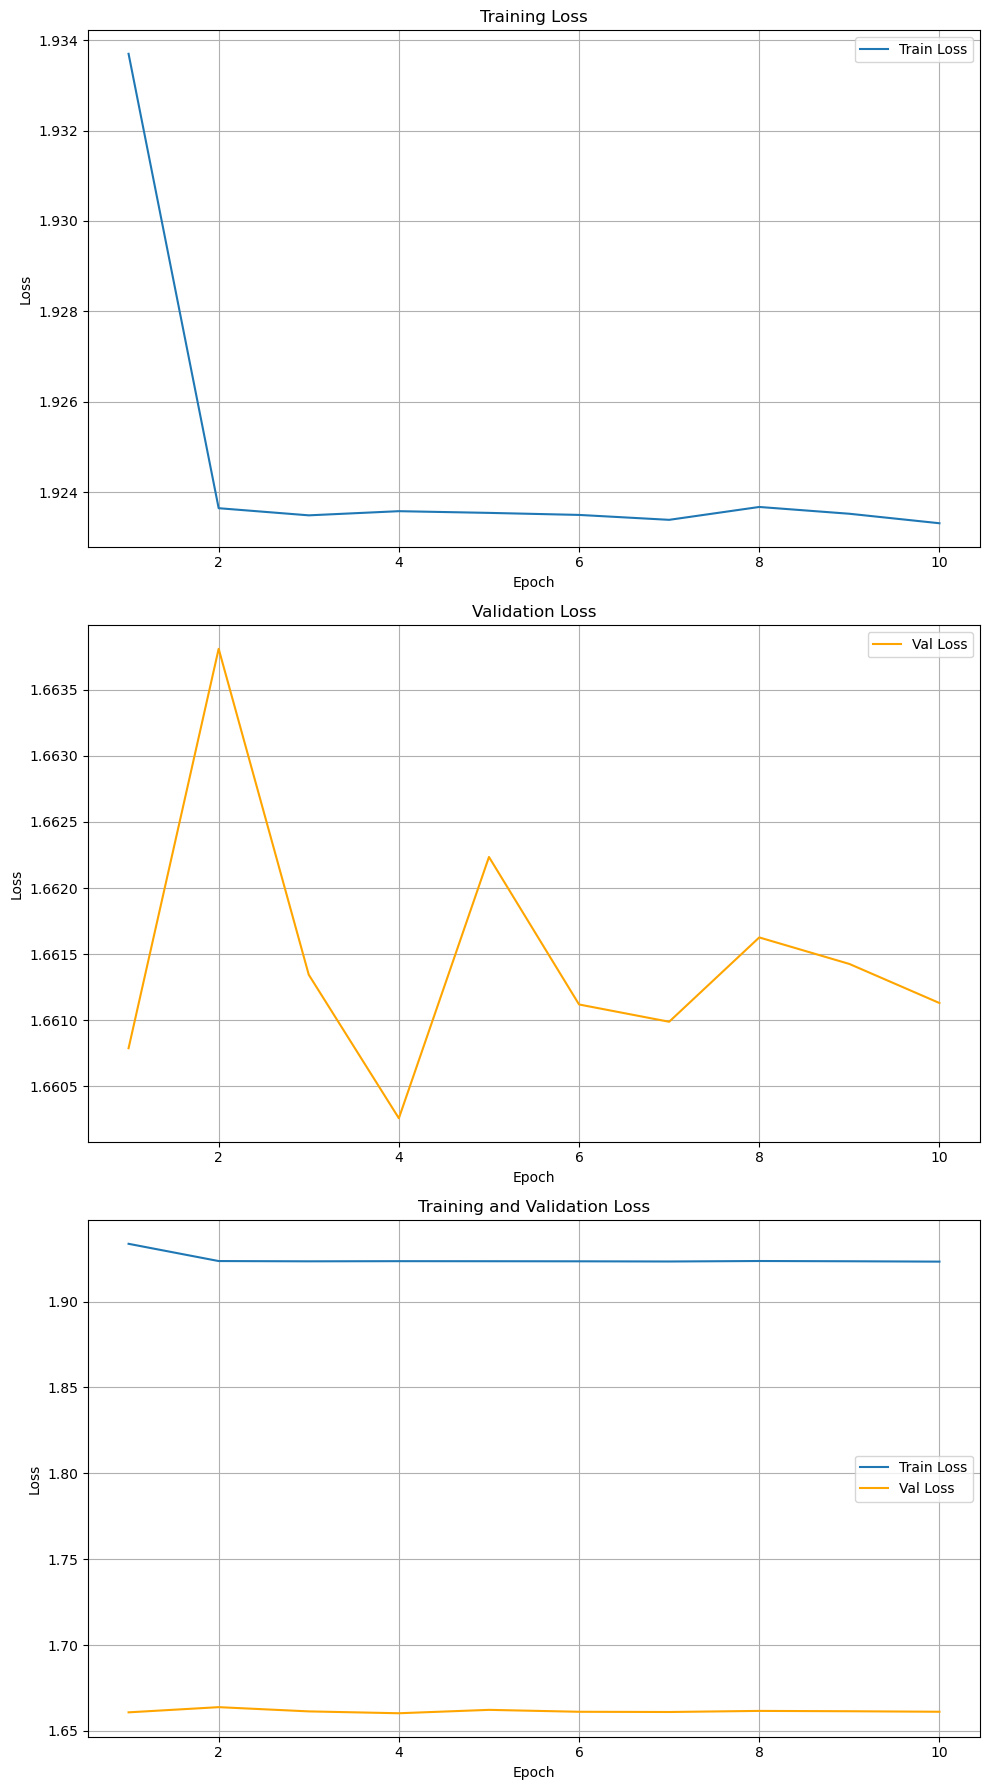

In [19]:
# Create figure and axes
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot train_losses
axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[0].legend()
axs[0].grid(True)

# Plot val_losses
axs[1].plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Validation Loss')
axs[1].legend()
axs[1].grid(True)

# Plot both train_losses and val_losses in a combined plot
axs[2].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
axs[2].plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='orange')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].set_title('Training and Validation Loss')
axs[2].legend()
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### TODO#6

When does the model start to overfit?

**Ans:** epoch = 5, validation loss starting to increase while the training loss is still decreasing or stable

### TODO#7

Plot the learning rate as a function of the epochs.

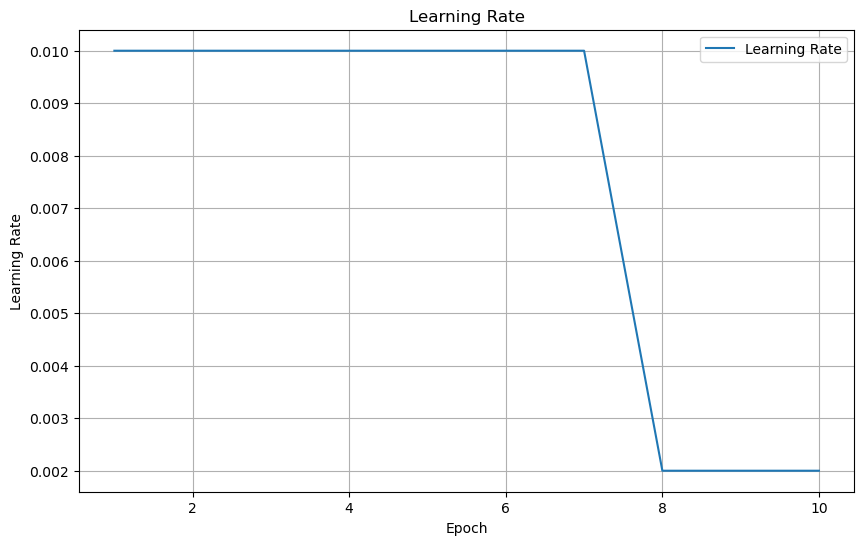

In [20]:
# Plot learning rate
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** The ReduceLROnPlateau scheduler reduces the learning rate when a specified metric stops improving. It uses a factor to reduce the learning rate, patience to wait for improvement, and min_lr to set a lower bound. This dynamic adjustment helps improve model performance and convergence.

# Load Model

Use the code snippet below to load the model you just trained

In [35]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 3 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

linear: y = mx + c \
lr = slope * epoch + c

In [26]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
        pass

    def step(self, epoch):
        # Changes the learning rate here
        if epoch <= 3:
            lr = 3/10000 * epoch + 1e-4
        elif epoch <= 6:
            lr = -1/6000 * (epoch-3) + 1e-3
        elif epoch <= 7:
            lr = 1/2000 * (epoch-6) + 5e-4
        elif epoch <= 9:
            lr = -9/20000 * (epoch-7) + 1e-3
        self.optimizer.param_groups[0]['lr'] = lr
        return lr

In [27]:
# Now train with your scheduler
# my_scheduler = MyScheduler(...)

# Hyperparameters and other configs
config_my_scheduler = {
    'architecture': 'feedforward_my_scheduler',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
# Now train with your scheduler
model_ff_my_scheduler = FeedForwardNN(hidden_size=config_my_scheduler['hidden_size'])
model_ff_my_scheduler = model_ff_my_scheduler.to(device)
optimizer_my_scheduler = torch.optim.Adam(model_ff_my_scheduler.parameters(), lr=config_my_scheduler['lr'])
my_scheduler = MyScheduler(optimizer_my_scheduler)

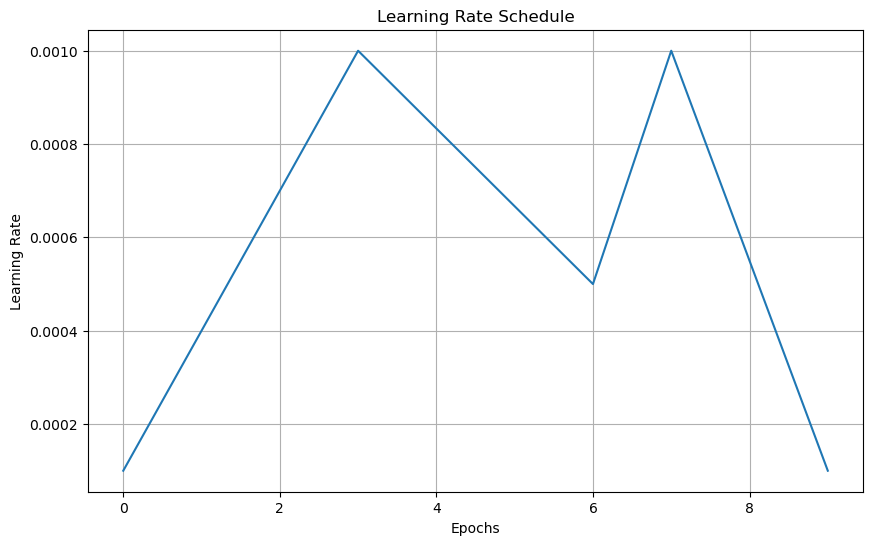

In [29]:
lr_my_scheduler = []
for i in range(config_my_scheduler["epochs"]):
    lr_my_scheduler.append(my_scheduler.step(i))

X = np.arange(config_my_scheduler['epochs'])
plt.figure(figsize=(10, 6))
plt.plot(X, lr_my_scheduler)
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

In [30]:
optimizer_my_scheduler = torch.optim.Adam(model_ff_my_scheduler.parameters(), lr=config['lr'])
my_scheduler = MyScheduler(optimizer_my_scheduler)

In [32]:
train_losses_my_scheduler = []
val_losses_my_scheduler = []
learning_rates_my_scheduler = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config_my_scheduler,
)

# Log parameters and gradients
wandb.watch(model_ff_my_scheduler, log='all')

for epoch in range(config_my_scheduler['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer_my_scheduler.param_groups[0]['lr']
    learning_rates_my_scheduler.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_my_scheduler.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer_my_scheduler.zero_grad()

        # Predict
        y_pred = model_ff_my_scheduler(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer_my_scheduler.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_my_scheduler.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff_my_scheduler.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff_my_scheduler(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_my_scheduler.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with my_scheduler
        my_scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_my_scheduler[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_my_scheduler.state_dict(),
                'optimizer': optimizer_my_scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff_my_scheduler.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9229
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6606
Saving new best model..
Training epoch 2...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9229
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6601
Saving new best model..
Training epoch 3...
Current LR: 0.00039999999999999996


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9207
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6575
Saving new best model..
Training epoch 4...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9199
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6570
Saving new best model..
Training epoch 5...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9196
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6586
Training epoch 6...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9193
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6571
Training epoch 7...
Current LR: 0.0006666666666666668


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9206
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6569
Saving new best model..
Training epoch 8...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9183
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6560
Saving new best model..
Training epoch 9...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9187
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6582
Training epoch 10...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9184
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6566


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁▁▃▆█▇▅▄█▄
train_loss,██▅▃▃▃▄▁▂▁
val_loss,█▇▃▃▅▃▂▁▄▂
lr,0.00055
train_loss,1.91844
val_loss,1.65663


Finished Training


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:**

# Evaluation

In [105]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    wandb.init(
        project='precipitation-nowcasting',
    )

    # Log parameters and gradients
    wandb.watch(model, log='all')
    with torch.no_grad():
      train_losses = []
      for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Predict
        y_pred = model(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Log stuff
        train_losses.append(loss)

      mse = torch.stack(train_losses).mean()
      wandb.finish()
    return mse

In [99]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [ ]:
print('FF-model')
print('train', evaluate(train_loader, model_ff).item())
print('validate', evaluate(val_loader, model_ff).item())

# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [41]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardNNWithDropout(nn.Module):
    def __init__(self, hidden_size=200, p=0.2):
        super(FeedForwardNNWithDropout, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.nn1 = nn.Dropout(p=p)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.nn2 = nn.Dropout(p=p)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.nn3 = nn.Dropout(p=p)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd_drop1 = self.nn1(hd1)
        hd2 = F.relu(self.ff2(hd_drop1))
        hd_drop2 = self.nn2(hd2)
        hd3 = F.relu(self.ff3(hd_drop2))
        hd_drop3 = self.nn3(hd3)
        y = self.out(hd_drop3)
        return y.reshape(-1, 1)

In [42]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

# Hyperparameters and other configs
config_dropout = {
    'architecture': 'feedforward_dropout',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10,
    'p': 0.2
}

# Model
# Now train with your scheduler
model_ff_dropout = FeedForwardNNWithDropout(hidden_size=config_dropout['hidden_size'], p=config_dropout["p"])
model_ff_dropout = model_ff_dropout.to(device)
optimizer_dropout = torch.optim.Adam(model_ff_dropout.parameters(), lr=config_dropout['lr'])
scheduler_dropout = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_dropout, 
    'min', 
    factor=config_dropout['scheduler_factor'], 
    patience=config_dropout['scheduler_patience'], 
    min_lr=config_dropout['scheduler_min_lr']
)

train_losses_dropout = []
val_losses_dropout = []
learning_rates_dropout = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config_dropout,
)

# Log parameters and gradients
wandb.watch(model_ff_dropout, log='all')

for epoch in range(config_dropout['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer_dropout.param_groups[0]['lr']
    learning_rates_dropout.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_dropout.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer_dropout.zero_grad()

        # Predict
        y_pred = model_ff_dropout(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer_dropout.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_dropout.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff_dropout.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff_dropout(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_dropout.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with my_scheduler
        scheduler_dropout.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_dropout[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_dropout.state_dict(),
                'optimizer': optimizer_dropout.state_dict(),
                'scheduler': scheduler_dropout.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff_dropout.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training ff dropout


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9280
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6580
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9219
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6607
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9215
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6629
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9221
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6585
Training epoch 5...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9212
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6589
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9218
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6594
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9210
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6583
Training epoch 8...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9205
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6576
Saving new best model..
Training epoch 9...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9207
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6578
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9204
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6580


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,████▂▂▂▁▁▁
train_loss,█▂▂▃▂▂▂▁▁▁
val_loss,▂▅█▂▃▃▂▁▁▁
lr,0.0004
train_loss,1.92041
val_loss,1.65796


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

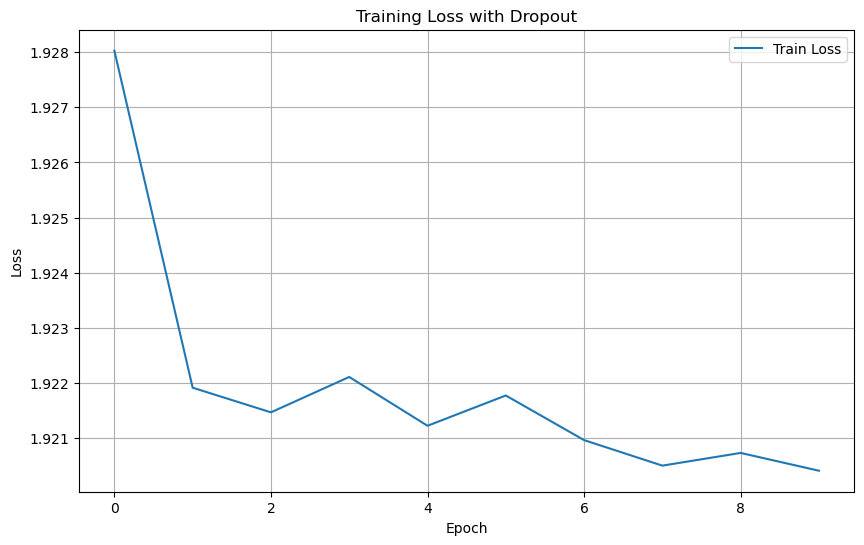

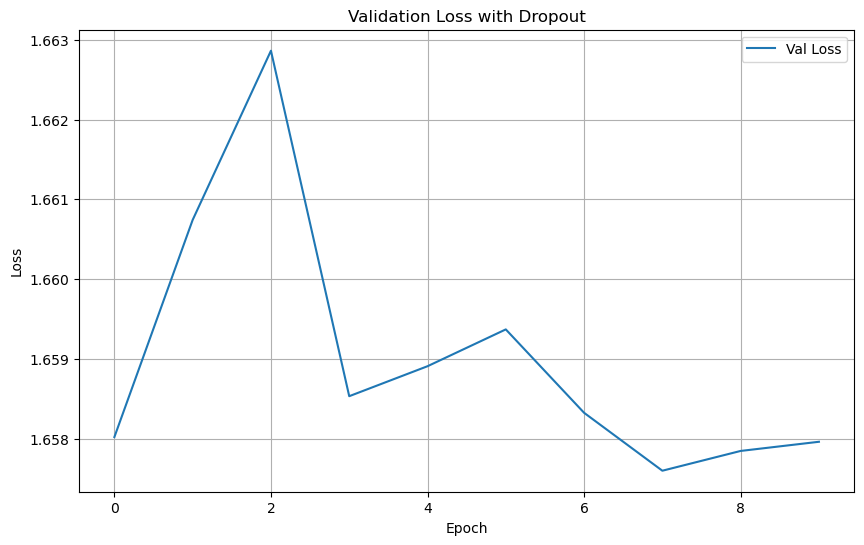

In [45]:
# Plot here
plt.figure(figsize=(10, 6))
plt.plot(X, train_losses_dropout, label='Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training Loss with Dropout')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(X, val_losses_dropout, label='Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Validation Loss with Dropout')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
# Evaluate
evaluated_train_dropout = evaluate(train_loader, model_ff_dropout).item()
evaluated_val_dropout = evaluate(val_loader, model_ff_dropout).item()

print('dropout-model')
print('train', evaluated_train_dropout)
print('validate', evaluated_val_dropout)

  0%|          | 0/1121 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/454 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


dropout-model
train 1.9196616411209106
validate 1.6579608917236328


# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [48]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def to_cnn(x):
    return torch.reshape(x, (-1, 3, 5, 5))

In [49]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class CNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(3, hidden_size, 3)
        self.ff1 = nn.Linear(hidden_size * 3 * 3, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        con = F.relu(self.cn1(x))
        flat = torch.flatten(con, 1)
        hd1 = F.relu(self.ff1(flat))
        y = F.relu(self.ff2(hd1))
        y = self.out(y)
        return y.reshape(-1, 1)

In [50]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

# Hyperparameters and other configs
config_cnn = {
    'architecture': 'cnn',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10,
}
# Model
model_cnn = CNN(hidden_size=config_cnn['hidden_size'])
model_cnn = model_cnn.to(device)
summary(model_cnn, input_size=(1024, 3, 5, 5))

# Now train with your scheduler
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=config_cnn['lr'])
scheduler_cnn = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cnn, 
    'min', 
    factor=config_cnn['scheduler_factor'], 
    patience=config_cnn['scheduler_patience'], 
    min_lr=config_cnn['scheduler_min_lr']
)

train_losses_cnn = []
val_losses_cnn = []
learning_rates_cnn = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config_cnn,
)

# Log parameters and gradients
wandb.watch(model_cnn, log='all')

for epoch in range(config_cnn['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer_cnn.param_groups[0]['lr']
    learning_rates_cnn.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_cnn.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer_cnn.zero_grad()

        # Predict
        y_pred = model_cnn(to_cnn(inputs))

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer_cnn.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_cnn.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_cnn.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_cnn(to_cnn(inputs))

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_cnn.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with my_scheduler
        scheduler_cnn.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_cnn[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_cnn.state_dict(),
                'optimizer': optimizer_cnn.state_dict(),
                'scheduler': scheduler_cnn.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_cnn.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training conv2d


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 2.0613
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6585
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9197
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6589
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9194
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6569
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9195
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6580
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9193
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6573
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9225
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6608
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9231
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6602
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9232
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6611
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9228
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6605
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9224
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6583


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,██████▂▂▂▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▄▄▁▃▂▇▆█▇▃
lr,0.0004
train_loss,1.92241
val_loss,1.65832


Finished Training


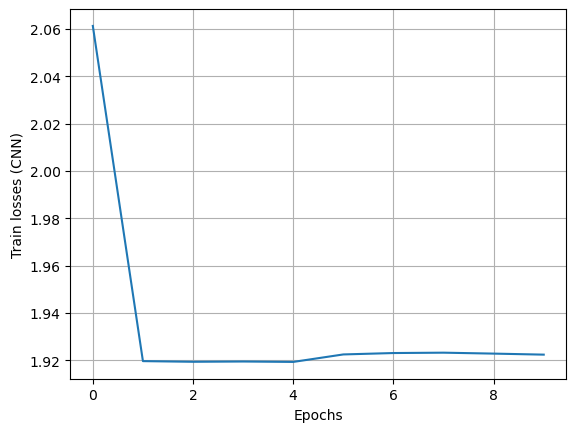

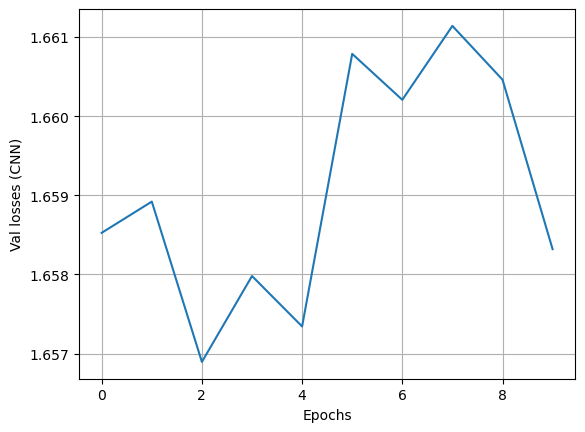

In [51]:
# Plot losses
X = np.arange(config_cnn['epochs'])
plt.plot(X, train_losses_cnn)
plt.ylabel("Train losses (CNN)")
plt.xlabel("Epochs")
plt.grid(True)
plt.show()

plt.plot(X, val_losses_cnn)
plt.ylabel("Val losses (CNN)")
plt.xlabel("Epochs")
plt.grid(True)
plt.show()

In [52]:
# Evaluate
def evaluate_cnn(data_loader, model):
    wandb.init(
        project='precipitation-nowcasting',
    )

    # Log parameters and gradients
    wandb.watch(model, log='all')
    with torch.no_grad():
      train_losses = []
      for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Predict
        y_pred = model(to_cnn(inputs))

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Log stuff
        train_losses.append(loss)

      mse = torch.stack(train_losses).mean()
      wandb.finish()
      return mse

evaluated_train_cnn = evaluate_cnn(train_loader, model_cnn).item()
evaluated_val_cnn = evaluate_cnn(val_loader, model_cnn).item()

print('cnn-model')
print('train', evaluated_train_cnn)
print('validate', evaluated_val_cnn)

  0%|          | 0/1121 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/454 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


cnn-model
train 1.9213995933532715
validate 1.6583198308944702


# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [69]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

def preprocess_for_gru(x_train, y_train, x_val, y_val, x_test, y_test):
    x_train_gru = x_train.reshape((-1, 5, 5*5*3))
    y_train_gru = y_train.reshape((-1, 5))
    x_val_gru = x_val.reshape((-1, 5, 5*5*3))
    y_val_gru = y_val.reshape((-1, 5))
    x_test_gru = x_test.reshape((-1, 5, 5*5*3))
    y_test_gru = y_test.reshape((-1, 5))

    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val, x_test, y_test)
print(x_train_gru.shape, y_train_gru.shape)
print(x_val_gru.shape, y_val_gru.shape)
print(x_test_gru.shape, y_test_gru.shape)


(229548, 5, 75) (229548, 5)
(92839, 5, 75) (92839, 5)
(111715, 5, 75) (111715, 5)


In [70]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class GRU(nn.Module):
    def __init__(self, hidden_size=200):
        super(GRU, self).__init__()
        self.gru = nn.GRU(5*5*3, hidden_size, batch_first=True)
        self.ff1 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        hd1 = F.relu(self.ff1(gru_out))
        y = self.out(hd1)
        return y

# Assuming your input tensor x has shape (batch_size, 5, 75)
# Example usage
model_gru = GRU(hidden_size=200)
x = torch.randn(1024, 5, 75)  # Example input tensor
output = model_gru(x)
print(output.shape)  # Should be (batch_size, 5, 1)

torch.Size([1024, 5, 1])


In [71]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

config_gru = {
    'architecture': 'gru',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10,
}

model_gru = GRU(hidden_size=config_gru['hidden_size'])
model_gru = model_gru.to(device)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=config_gru['lr'])
scheduler_gru = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_gru, 
    'min', 
    factor=config_gru['scheduler_factor'], 
    patience=config_gru['scheduler_patience'], 
    min_lr=config_gru['scheduler_min_lr']
)

train_losses_gru = []
val_losses_gru = []
learning_rates_gru = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config_gru,
)

# Log parameters and gradients
wandb.watch(model_gru, log='all')

for epoch in range(config_gru['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer_gru.param_groups[0]['lr']
    learning_rates_gru.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_gru.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_gru)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer_gru.zero_grad()

        # Predict
        y_pred = model_gru(inputs)

        # Calculate loss
        y_pred = torch.reshape(y_pred, (-1, 5))
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer_gru.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_gru.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_gru.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_gru)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_gru(inputs)

            # Calculate loss
            y_pred = torch.reshape(y_pred, (-1, 5))
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_gru.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with my_scheduler
        scheduler_gru.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_gru[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_gru.state_dict(),
                'optimizer': optimizer_gru.state_dict(),
                'scheduler': scheduler_gru.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_gru.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')


start training gru


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training epoch 1...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9344
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6722
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9206
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6694
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9107
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6681
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9132
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6686
Training epoch 5...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9142
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6717
Training epoch 6...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9185
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6718
Training epoch 7...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9080
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6697
Training epoch 8...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9088
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6704
Training epoch 9...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9052
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6684
Training epoch 10...
Current LR: 0.0004


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9035
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6686


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,██████▂▂▂▁
train_loss,█▅▃▃▃▄▂▂▁▁
val_loss,█▃▁▂▇▇▄▅▁▂
lr,0.0004
train_loss,1.9035
val_loss,1.66863


Finished Training


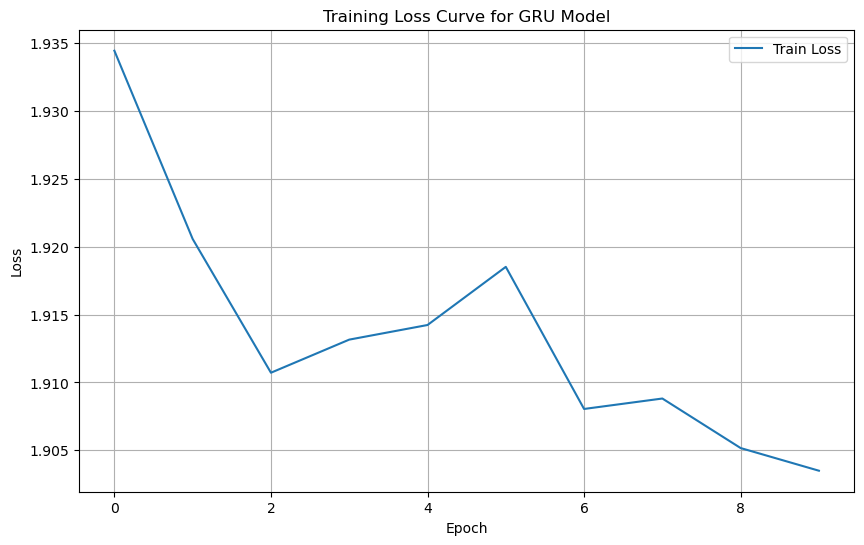

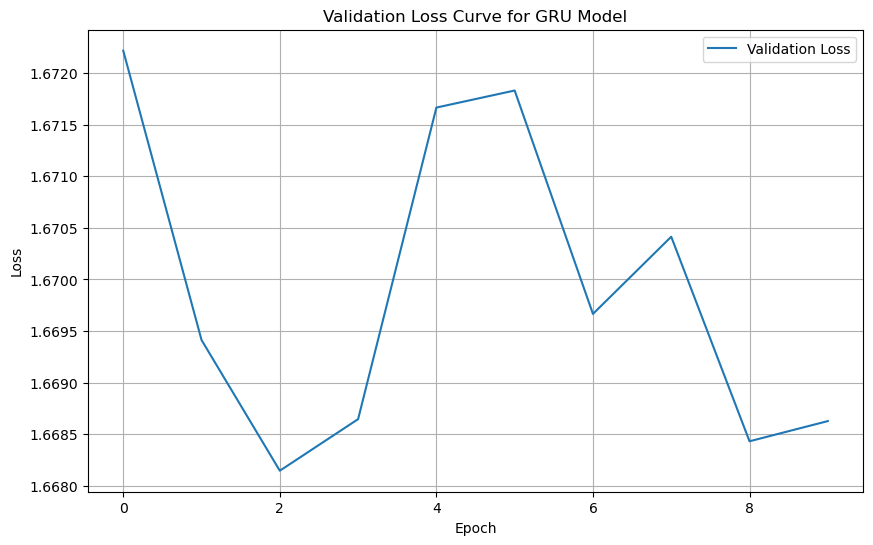

In [73]:
# Plot

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses_gru, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for GRU Model')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 6))
plt.plot(val_losses_gru, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve for GRU Model')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Evaluate

def evaluate_gru(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    # Start wandb run
    wandb.init(
        project='precipitation-nowcasting',
    )

    # Log parameters and gradients
    wandb.watch(model, log='all')
    with torch.no_grad():
      train_losses = []
      for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Predict
        y_pred = model(inputs)

        # Calculate loss
        y_pred = torch.reshape(y_pred, (-1, 5))
        loss = loss_fn(y_pred, y_true)

        # Log stuff
        train_losses.append(loss)

      mse = torch.stack(train_losses).mean()
      wandb.finish()
      return mse
  
evaluated_train_gru = evaluate_gru(train_loader_gru, model_gru).item()
evaluated_val_gru = evaluate_gru(val_loader_gru, model_gru).item()

print('gru-model')
print('train', evaluated_train_gru)
print('validate', evaluated_val_gru)

  0%|          | 0/225 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/91 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


gru-model
train 1.9049019813537598
validate 1.668627381324768


# Transformer

Welcome to the beginning of the real world! The aboved models are not usually used in practice due to its limited capability. Transformers are generally used by computer vision, natural language processing, and speech processing (almost every big AI fields).



In our dataloader, we will add the output of this timestep (the number of precipitation) as an auxiliary input to predict the next timestep. Thus, input for the model should be [#batch_size, 5, 76] (5 timesteps and the number 76 comes from (3x5x5)+1) and the output for the model should be [#batch_size, 1] which would be the next timestep we want to predict. Additionally, we will mask the input at the dataloader to the attenttion from observing future values. Suppose that we want to predict timestep 3, we will mask the timestep 3, 4 and 5 in our input by setting it to zeros, and we will predict the timestep 3.

In order to get a score on this TODO, students need to implement a dataloader that mask the input correctly.

In [ ]:
################################################################################
# OT#2:                                                                        #
# Complete the code for preparing data for training Transformer                #
# Transformer's input should has 3 dimensions.                                 #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In this task, we will implement one encoder layer of Transformer and add the linear layer to make a regression prediction. For the simplicity of the model, we will change the multi-head attention to QKV self-attention (single-head). As a result, our model should look like the diagram below. Since the layer self-attention is not availble in torch, students have to implement it themselves. In Add & Norm layer, students have to do the addition before normalizing. In Layer Normalization, we will normalize across both timesteps and features.

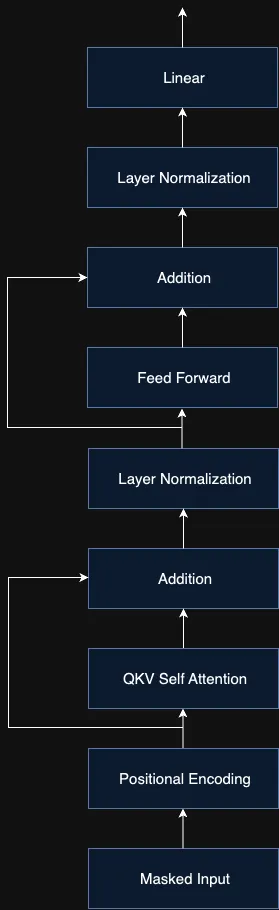

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
TransformerModel                         [1024, 1]                 --
├─PositionalEncoding: 1-1                [1024, 5, 76]             --
│    └─Dropout: 2-1                      [1024, 5, 76]             --
├─SelfAttention: 1-2                     [1024, 5, 76]             --
│    └─Linear: 2-2                       [1024, 5, 76]             5,852
│    └─Linear: 2-3                       [1024, 5, 76]             5,852
│    └─Linear: 2-4                       [1024, 5, 76]             5,852
│    └─Softmax: 2-5                      [1024, 5, 5]              --
├─LayerNorm: 1-3                         [1024, 5, 76]             760
├─Linear: 1-4                            [1024, 5, 76]             5,852
├─LayerNorm: 1-5                         [1024, 5, 76]             760
├─Linear: 1-6                            [1024, 1]                 381
==========================================================================================
Total params: 25,309
Trainable params: 25,309
Non-trainable params: 0
Total mult-adds (M): 25.92
==========================================================================================
Input size (MB): 1.56
Forward/backward pass size (MB): 18.69
Params size (MB): 0.10
Estimated Total Size (MB): 20.34
==========================================================================================
```

In [ ]:
################################################################################
# OT#3                                                                         #
# Write a PyTorch PositionalEncoding model.                                    #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class PositionalEncoding(nn.Module):
  def __init__(self, seq_len, emb_dim, dropout=0.2):
    pass

  def forward(self, x):
    pass

In [ ]:
################################################################################
# OT#4                                                                         #
# Write a PyTorch Transformer model.                                           #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class SelfAttention(nn.Module):
  def __init__(self, input_dim):
    pass

  def forward(self, x):
    pass

class TransformerModel(nn.Module):
  def __init__(self):
    pass

  def forward(self, x):
    pass


In [ ]:
################################################################################
# OT#5                                                                         #
# Complete the code to train your Transformer model                                    #
################################################################################
print('start training transformer')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

In [ ]:
# Plot

If you implement it correctly, you should evaluate the model in the test dataset and the score should be better than the aboved models.

In [ ]:
# Evaluate

# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [ ]:
# Prep data as you see fit


In [84]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class BestModel(nn.Module):
    def __init__(self, hidden_size=200, dropout=0.5):
        super(BestModel, self).__init__()
        self.gru = nn.GRU(3 * 5 * 5, hidden_size, 5, dropout=dropout)
        self.ff1 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru = self.gru(x)
        hd1 = F.relu(self.ff1(gru[0]))
        y = self.out(hd1)
        return y


In [85]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config_best_model = {
    'architecture': 'best_model',
    'lr': 0.01,
    'hidden_size': 200,
    'dropout': 0.5,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 1,
}

best_model = BestModel(hidden_size=config_best_model['hidden_size'], dropout=config_best_model['dropout'])
best_model = best_model.to(device)
optimizer_best_model = torch.optim.Adam(best_model.parameters(), lr=config_best_model['lr'])
scheduler_best_model = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_best_model, 
    'min', 
    factor=config_best_model['scheduler_factor'], 
    patience=config_best_model['scheduler_patience'], 
    min_lr=config_best_model['scheduler_min_lr']
)

for epoch in range(config_best_model['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer_best_model.param_groups[0]['lr']
    
    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    best_model.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader_gru)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer_best_model.zero_grad()

        # Predict
        y_pred = best_model(inputs)

        # Calculate loss
        y_pred = torch.reshape(y_pred, (-1, 5))
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer_best_model.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    best_model.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader_gru)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = best_model(inputs)

            # Calculate loss
            y_pred = torch.reshape(y_pred, (-1, 5))
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with my_scheduler
        scheduler_best_model.step(avg_val_loss)

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training the best model
start training the best model
Training epoch 1...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9802
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6795


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


lr,▁
train_loss,▁
val_loss,▁
lr,0.01
train_loss,1.98022
val_loss,1.67952


Finished Training


In [86]:
# Evaluate best model on validation and test set
def evaluate_best_model(data_loader, model):
    """
    Evaluate model on validation or test data given by data_loader
    """
    # Start wandb run
    wandb.init(
        project='precipitation-nowcasting',
    )

    # Log parameters and gradients
    wandb.watch(model, log='all')
    with torch.no_grad():
        losses = []
        for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model(inputs)

            # Calculate loss
            y_pred = torch.reshape(y_pred, (-1, 5))
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            losses.append(loss)

        avg_loss = torch.stack(losses).mean()
        wandb.finish()
        return avg_loss.item()

evaluated_val_best_model = evaluate_best_model(val_loader_gru, best_model)
evaluated_test_best_model = evaluate_best_model(test_loader_gru, best_model)

print('Best model')
print('Validation Loss:', evaluated_val_best_model)
print('Test Loss:', evaluated_test_best_model)

  0%|          | 0/91 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/110 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best model
Validation Loss: 1.6795189380645752
Test Loss: 1.16172194480896


In [ ]:
# Also evaluate your fully-connected model and CNN/GRU/Transformer model on the test set.
evaluated_test_cnn = evaluate_cnn(test_loader, model_cnn).item()
evaluated_test_gru = evaluate_gru(test_loader_gru, model_gru).item()

print('test my_scheduler', evaluated_test_my_scheduler)
print('test dropout', evaluated_test_dropout)
print('test cnn', evaluated_test_cnn)
print('test gru', evaluated_test_gru)
print('test best model', evaluated_test_best_model)

To get full credit for this part, your best model should be better than the previous models on the **test set**.

### TODO#22

Explain what helped and what did not help here

**Ans:** Adding dropout to the GRU model's output (dropout=0.5) can improve generalization by preventing overfitting, although its effectiveness varies. Experimenting with different dropout rates and architectures is crucial for optimizing performance.

# [Optional] Augmentation using data loader

### Optional TODO#6

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [ ]:
# Write Dataset/DataLoader with noise here


In [ ]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate the best model trained with noise on validation and test set
